# Setup

In [2]:
# handle math and data
import numpy as np
import pandas as pd
import time
import math

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import sys
import joblib

# random states
SEED = 69

# deep learning
import tensorflow as tf
from tensorflow import keras

K = keras.backend

def reset_backend():
    K.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# model directory
MODEL_DIR = os.path.join(".", "_tf_models", "my_cifar10")
os.makedirs(MODEL_DIR, exist_ok=True)

# tensorboard directory
LOG_DIR = os.path.join(".", "_tf_logs", "my_cifar10")
os.makedirs(LOG_DIR, exist_ok=True)

# Get Data

We need to get the CIFAR10 dataset and understand the data shapes, types, features, labels, etc.
- load data with **[cifar10.load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)**
- explore data

In [3]:
from tensorflow.keras.datasets import cifar10

(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train_full.shape, X_train_full.dtype

((50000, 32, 32, 3), dtype('uint8'))

In [4]:
np.unique(y_train_full, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

Let's split train into train and validation sets.

In [5]:
val_size = 5000

X_train, X_val = X_train_full[val_size:], X_train_full[:val_size]
y_train, y_val = y_train_full[val_size:], y_train_full[:val_size]

X_train.shape

(45000, 32, 32, 3)

Let's see if the validation set is stratified.

In [6]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([505, 460, 519, 486, 519, 488, 519, 486, 520, 498]))

Good, about 500 of each class.

## Visualize Samples

Now let's create a function for plotting these instances.

In [7]:
X_train[0].shape

(32, 32, 3)

In [8]:
def plot_image(image):    
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

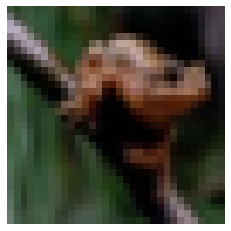

In [9]:
plot_image(X_train[0])

Let's have label names available.

In [10]:
y_train.shape

(45000, 1)

In [12]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

y_train.shape

(45000,)

In [13]:
attribute_names = ["airplane", "automobile", "bird", "cat", 
                   "deer", "dog", "frog", "horse", "ship", "truck",]

attribute_names[y_train[0]]

'frog'

Let's make a function for visualizing arrays of samples.

In [14]:
def plot_images(X, y, n_rows=4, n_cols=10):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X[index], interpolation="nearest")
            plt.axis('off')
            plt.title(attribute_names[y[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

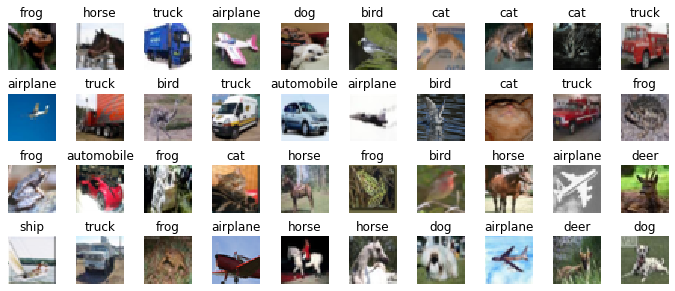

In [15]:
plot_images(X_train, y_train)

Looks good.

# First Model

For our first model, we need to do the following:
- First build an exploratory deep NN with 20 layers and 100 neurons per layer. We will use He initialization and the ELU activation function.
    - Input layer should flatten the (32, 32, 3) shape
    - Build a sequential model with 20 hidden layers using He init and ELU activation
    - Output layer is 10 neurons with He init softmax activation
- Then find optimal learning rate (smaller is better than bigger, we don't want divergence, especially in a DNN)
    - Custom callback class that increases learning rate by some factor after each iteration
    - Function that saves initial weight and lr, then trains model with exponential lr callback, then restore initial weight and lr of model afterwards
    - Function that plots the rates and losses
- Finally, we can train our first model using the optimal lr and callbacks
    - Callbacks: early stopping, model checkpoint, tensorboard
    - The learning rate is truly the most important thing, if the model's loss suddenly spikes after a period of decreasing loss then the lr is most likely too big

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="elu", 
                    kernel_initializer="he_normal"))
model.add(Dense(10, activation="softmax"))

## Optimal LR

Referenced from handsonml **[here](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb)**.
<br>
For the code below:
- We first create a `Callback` class that stores rates and losses after each iteration and multiplies the learning rate by some factor
- Then we create a function that takes in the model (that is already created and compiled), training data, epochs to train, starting learning rate, and final learning rate
    - The function saves initial weights and learning rate of the model
    - Then calculates the factor to multiply by at every iteration so that after some epochs, we reach the final learning rate
        - The math behind this is simply a log rule and some algebra
    - Then it trains aka fits the model to the provided data with the expon lr callback using the calculated factor
    - It sets the model's weights and learning rate back to the original values (so we don't have to reset model)
    - Finally the rates and losses arrays are returned as tuple
- Finally we create a function that plots losses vs rates and automatically zooms in on the important section

In [93]:
def round_up_to_tenth(n):
    a = np.log(n) / np.log(10)
    a_ = np.rint(a)
    return 10**a_

round_up_to_tenth(8e-7)

1e-06

In [246]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-10, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses, max_loss=None):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    
    tick = round_up_to_tenth(min(rates))
    x_ticks = []
    while tick < max(rates)*10:
        x_ticks.append(tick)
        tick = tick * 10
    plt.gca().set_xticks(x_ticks)
    
    plt.hlines(min(losses), min(rates), max(rates))
    if max_loss is None:
        plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    else:
        plt.axis([min(rates), max(rates), min(losses), max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [33]:
from tensorflow.keras.optimizers import Nadam

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=1e-5),
              metrics=["accuracy"])

In [35]:
rates, losses = find_learning_rate(model, X_train, y_train,
                                   epochs=5, min_rate=1e-10, max_rate=1e-1)

Epoch 1/5
1407/1407 [==============================] - 10s 6ms/step - loss: 257.6057 - accuracy: 0.1187
Epoch 2/5
1407/1407 [==============================] - 8s 6ms/step - loss: 217.0621 - accuracy: 0.1191
Epoch 3/5
1407/1407 [==============================] - 8s 6ms/step - loss: 46.8183 - accuracy: 0.1136
Epoch 4/5
1407/1407 [==============================] - 8s 6ms/step - loss: 3.0016 - accuracy: 0.1590
Epoch 5/5
1407/1407 [==============================] - 8s 6ms/step - loss: 24541432.0000 - accuracy: 0.1288


Great, now let's plot.

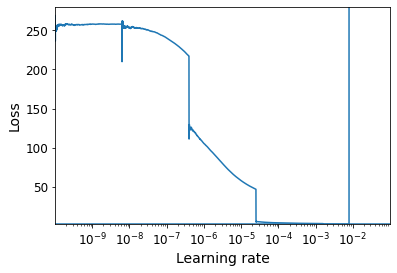

In [38]:
plot_lr_vs_loss(rates, losses, max_loss=280)

So we could set optimal learning rate to any of these values:
- 4e-2 (this has a high risk of diverging soon after training for 1 or 2 epochs)
- 3e-4 (this has a low risk of diverging late into training, can use a simple decay to fix)
- 1e-5 (This would take longer in the beginning, but have little risk of diverging late into training)

Let's use a simple exponential decay schedule for the learning rate. Documenation **[here](https://keras.io/api/callbacks/learning_rate_scheduler/)**.

In [53]:
decay = 0.1

def exponential_decay(lr0=1e-3, s=10):
    def exponential_decay_fn(epoch):
        return lr0 * decay**(epoch / s)
    return exponential_decay_fn

lr_scheduler_cb = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=5e-4, s=30))

## Train Model

**Callbacks**

In [54]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

cp_model_name = os.path.join(MODEL_DIR, "first_model_checkpoint.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(cp_model_name, save_best_only=True)

run_index = 2
run_logdir = os.path.join(LOG_DIR, "first_model_run_{:02d}".format(run_index))
print("TensorBoard directory:", run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

TensorBoard directory: ./_tf_logs/my_cifar10/first_model_run_02


In [55]:
callbacks = [lr_scheduler_cb, early_stopping_cb, checkpoint_cb, tensorboard_cb]

**Train**

In [56]:
reset_backend()

# re-init after prev run
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="elu", 
                    kernel_initializer="he_normal"))
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=1e-5),
              metrics=["accuracy"])

# train
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 12s 6ms/step - loss: 3.0854 - accuracy: 0.2054 - val_loss: 1.9807 - val_accuracy: 0.2744 - lr: 5.0000e-04
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.9217 - accuracy: 0.2959 - val_loss: 1.9099 - val_accuracy: 0.3044 - lr: 4.6306e-04
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8412 - accuracy: 0.3289 - val_loss: 1.8231 - val_accuracy: 0.3424 - lr: 4.2885e-04
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7991 - accuracy: 0.3466 - val_loss: 1.9387 - val_accuracy: 0.3130 - lr: 3.9716e-04
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7496 - accuracy: 0.3632 - val_loss: 1.7770 - val_accuracy: 0.3666 - lr: 3.6782e-04
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7081 - accuracy: 0.3782 - val_loss: 1.7331 - val_accuracy: 0.3678 - lr: 3.4065e-04
Epoch 7/100
1407/1407 [====

## Evaluate

In [57]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5688 - accuracy: 0.4604


[1.5687525272369385, 0.4603999853134155]

About `46.0%` accuracy.

# Batch Normalization

Let's try training the model, but with BN layers now.
- Create model with batch normalization. Documentation **[here](https://keras.io/api/layers/normalization_layers/batch_normalization/)**.
    - Just add a batch normalization layer after the first layer and each hidden layer
- Find optimal learning rate
    - Try using a piecewise learning rate schedule
- Train with callbacks

## Model

In [59]:
from tensorflow.keras.layers import BatchNormalization

reset_backend()

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
model.add(BatchNormalization())
for _ in range(20):
    model.add(Dense(100, activation="elu", 
                    kernel_initializer="he_normal"))
    model.add(BatchNormalization())
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=1e-5),
              metrics=["accuracy"])

## Optimal LR

In [65]:
rates, losses = find_learning_rate(model, X_train, y_train,
                                   epochs=5, min_rate=1e-10, max_rate=5)

Epoch 1/5
1407/1407 [==============================] - 14s 10ms/step - loss: 3.0899 - accuracy: 0.0997
Epoch 2/5
1407/1407 [==============================] - 13s 10ms/step - loss: 3.0858 - accuracy: 0.0975
Epoch 3/5
1407/1407 [==============================] - 14s 10ms/step - loss: 2.6293 - accuracy: 0.1471
Epoch 4/5
1407/1407 [==============================] - 13s 9ms/step - loss: 1.9816 - accuracy: 0.2874
Epoch 5/5
1407/1407 [==============================] - 13s 10ms/step - loss: 418.9547 - accuracy: 0.1704


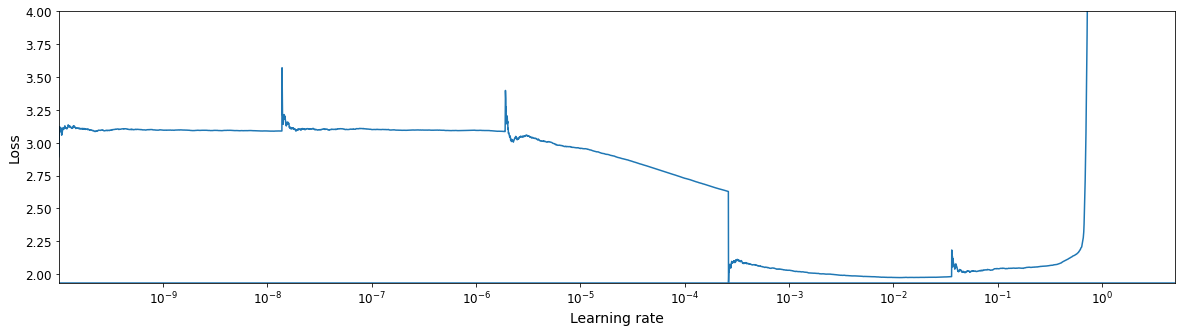

In [95]:
plt.figure(figsize=(20,5))
plot_lr_vs_loss(rates, losses, max_loss=4)

- Risky lr: `0.01` (10e-3)
- Safe lr: `0.001` (10e-4)
- Slow lr: `0.0006` (6e-5)

In [103]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 30:
        return 0.001
    else:
        return 0.0006

lr_scheduler_cb = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

## Train Model

**Callbacks**

In [104]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

model_id = "bn_model"

cp_model_name = os.path.join(MODEL_DIR, model_id + "_checkpoint.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(cp_model_name, save_best_only=True)

run_index = 2
run_logdir = os.path.join(LOG_DIR, model_id + "_run_{:02d}".format(run_index))
print("TensorBoard directory:", run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

callbacks = [lr_scheduler_cb, early_stopping_cb, checkpoint_cb, tensorboard_cb]

TensorBoard directory: ./_tf_logs/my_cifar10/bn_model_run_02


**Train**

In [105]:
reset_backend()

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
model.add(BatchNormalization())
for _ in range(20):
    model.add(Dense(100, activation="elu", 
                    kernel_initializer="he_normal"))
    model.add(BatchNormalization())
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=1e-5),
              metrics=["accuracy"])

# train
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 20s 10ms/step - loss: 2.0331 - accuracy: 0.2334 - val_loss: 2.2735 - val_accuracy: 0.2654 - lr: 0.0100
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8722 - accuracy: 0.3099 - val_loss: 2.2627 - val_accuracy: 0.2550 - lr: 0.0100
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.8114 - accuracy: 0.3398 - val_loss: 1.9670 - val_accuracy: 0.3236 - lr: 0.0100
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.7594 - accuracy: 0.3617 - val_loss: 1.9960 - val_accuracy: 0.3102 - lr: 0.0100
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.7166 - accuracy: 0.3747 - val_loss: 1.7976 - val_accuracy: 0.3914 - lr: 0.0100
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5914 - accuracy: 0.4221 - val_loss: 1.5297 - val_accuracy: 0.4378 - lr: 0.0010
Epoch 7/100
1407/1407 [=====================

## Evaluate

In [106]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.3842 - accuracy: 0.5139


[1.3842437267303467, 0.5138999819755554]

The training was slower than the first model, but the accuracy is better at at around `51.4%`.

# SELU

To use selu and successfully self-normalize we need to:
- Standardize inputs
- All hidden layer weights must be initialized with LeCun normal init
    - `"lecun_normal"

## Standardize Inputs

In [108]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_val_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

X_train_scaled.shape

(45000, 32, 32, 3)

## Model

In [109]:
reset_backend()

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="selu", 
                    kernel_initializer="lecun_normal"))
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=1e-5),
              metrics=["accuracy"])

## Optimal LR

In [110]:
rates, losses = find_learning_rate(model, X_train_scaled, y_train,
                                   epochs=5, min_rate=1e-10, max_rate=10)

Epoch 1/5
1407/1407 [==============================] - 11s 6ms/step - loss: 3.1626 - accuracy: 0.0956
Epoch 2/5
1407/1407 [==============================] - 9s 6ms/step - loss: 3.0042 - accuracy: 0.1109
Epoch 3/5
1407/1407 [==============================] - 9s 6ms/step - loss: 2.0732 - accuracy: 0.2724
Epoch 4/5
1407/1407 [==============================] - 9s 6ms/step - loss: 1703304960.0000 - accuracy: 0.1998
Epoch 5/5
1407/1407 [==============================] - 9s 6ms/step - loss: 14.6970 - accuracy: 0.0974


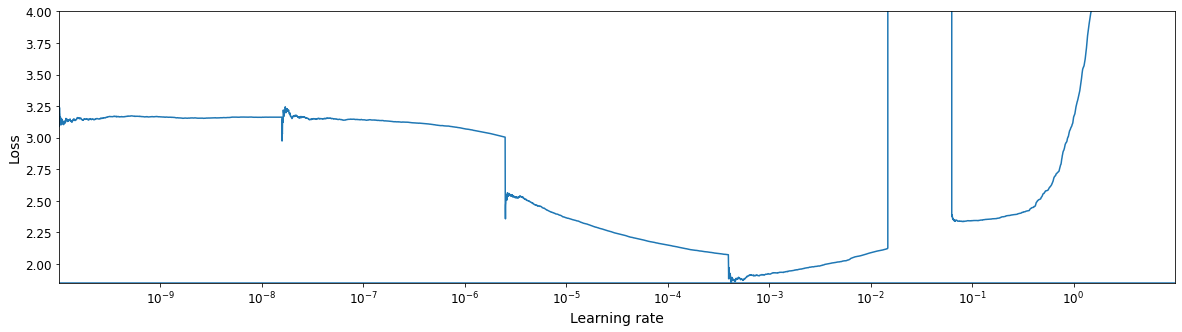

In [111]:
plt.figure(figsize=(20,5))
plot_lr_vs_loss(rates, losses, max_loss=4)

A safe lr should be approximately `3e-5`, and I also want to try using performance scheduling and reduce the learning rate by half for every 5 epochs that it doesn't improve validation error.

In [112]:
lr_scheduler_cb = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

## Train Model

**Callbacks**

In [113]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

model_id = "selu_model"

cp_model_name = os.path.join(MODEL_DIR, model_id + "_checkpoint.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(cp_model_name, save_best_only=True)

run_index = 1
run_logdir = os.path.join(LOG_DIR, model_id + "_run_{:02d}".format(run_index))
print("TensorBoard directory:", run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

callbacks = [lr_scheduler_cb, early_stopping_cb, checkpoint_cb, tensorboard_cb]

TensorBoard directory: ./_tf_logs/my_cifar10/selu_model_run_01


**Train**

In [114]:
reset_backend()

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="selu", 
                    kernel_initializer="lecun_normal"))
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=3e-5),
              metrics=["accuracy"])

# train
history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 11s 6ms/step - loss: 1.9370 - accuracy: 0.3139 - val_loss: 1.7480 - val_accuracy: 0.3772 - lr: 3.0000e-05
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6860 - accuracy: 0.4050 - val_loss: 1.6567 - val_accuracy: 0.4126 - lr: 3.0000e-05
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5845 - accuracy: 0.4387 - val_loss: 1.6076 - val_accuracy: 0.4332 - lr: 3.0000e-05
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5134 - accuracy: 0.4642 - val_loss: 1.5643 - val_accuracy: 0.4524 - lr: 3.0000e-05
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4555 - accuracy: 0.4846 - val_loss: 1.5466 - val_accuracy: 0.4546 - lr: 3.0000e-05
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4093 - accuracy: 0.5026 - val_loss: 1.5128 - val_accuracy: 0.4668 - lr: 3.0000e-05
Epoch 7/100
1407/1407 [====

Clearly overfitted the training set, but good thing we have early stopping and model checkpoints.

## Evaluate

In [115]:
model = keras.models.load_model(cp_model_name)
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5128 - accuracy: 0.4749


[1.5128167867660522, 0.4749000072479248]

Faster than batch normalization, but less accurate - at about `47.5%` accuracy.

# Alpha Dropout

Let's add alpha dropout to help prevent overfitting:
- Add an alpha dropout layer after input and each hidden layer. Docs **[here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout)**
- Find Optimal LR
- Train

## Model

I've tried adding dropout after every hidden layer, but it was too strong and the model was severely underfitting the training set (val and train loss converged to a similar value but a poor value).
- Thus, only add dropout after all the hidden layers (increase rate if overfitting, and decrease if underfitting)

In [182]:
from tensorflow.keras.layers import AlphaDropout

reset_backend()

rate = 0.2

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="selu", 
                    kernel_initializer="lecun_normal"))
model.add(AlphaDropout(rate=rate, seed=SEED))
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=1e-5),
              metrics=["accuracy"])

## Optimal LR

In [183]:
rates, losses = find_learning_rate(model, X_train_scaled, y_train,
                                   epochs=5, min_rate=1e-10, max_rate=10)

Epoch 1/5
1407/1407 [==============================] - 12s 7ms/step - loss: 3.1016 - accuracy: 0.0981
Epoch 2/5
1407/1407 [==============================] - 10s 7ms/step - loss: 3.0176 - accuracy: 0.1042
Epoch 3/5
1407/1407 [==============================] - 10s 7ms/step - loss: 2.3049 - accuracy: 0.2229
Epoch 4/5
1407/1407 [==============================] - 10s 7ms/step - loss: 12269331.0000 - accuracy: 0.2052
Epoch 5/5
1407/1407 [==============================] - 9s 7ms/step - loss: 64.7869 - accuracy: 0.0986


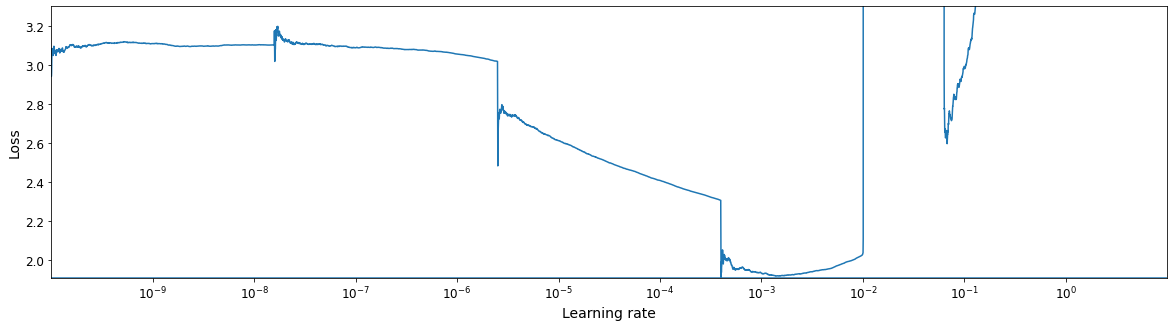

In [185]:
plt.figure(figsize=(20,5))
plot_lr_vs_loss(rates, losses, max_loss=3.3)

Similar to without dropout, a decent lr value should be `5e-5`

In [186]:
lr_scheduler_cb = keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5)

## Train Model

**Callbacks**

In [187]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

model_id = "alpha_dropout_model"

cp_model_name = os.path.join(MODEL_DIR, model_id + "_checkpoint.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(cp_model_name, save_best_only=True)

run_index = 9
run_logdir = os.path.join(LOG_DIR, model_id + "_run_{:02d}".format(run_index))
print("TensorBoard directory:", run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

callbacks = [lr_scheduler_cb, early_stopping_cb, checkpoint_cb, tensorboard_cb]

TensorBoard directory: ./_tf_logs/my_cifar10/alpha_dropout_model_run_09


**Train**

In [188]:
reset_backend()

rate = 0.2

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="selu", 
                    kernel_initializer="lecun_normal"))
model.add(AlphaDropout(rate=rate, seed=SEED))
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=5e-5),
              metrics=["accuracy"])

# train
history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 12s 6ms/step - loss: 2.0836 - accuracy: 0.2785 - val_loss: 1.7456 - val_accuracy: 0.3846 - lr: 5.0000e-05
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7508 - accuracy: 0.3780 - val_loss: 1.6637 - val_accuracy: 0.4240 - lr: 5.0000e-05
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6149 - accuracy: 0.4269 - val_loss: 1.6180 - val_accuracy: 0.4434 - lr: 5.0000e-05
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5261 - accuracy: 0.4582 - val_loss: 1.6345 - val_accuracy: 0.4468 - lr: 5.0000e-05
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4618 - accuracy: 0.4817 - val_loss: 1.5989 - val_accuracy: 0.4668 - lr: 5.0000e-05
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4053 - accuracy: 0.5005 - val_loss: 1.5782 - val_accuracy: 0.4762 - lr: 5.0000e-05
Epoch 7/100
1407/1407 [====

## Evaluate

In [189]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.9547 - accuracy: 0.4953


[1.9546632766723633, 0.4952999949455261]

`49.5%` accuracy! Quite good, although still slightly worse than batch normalization

# MC Dropout

Without re-training, let's add MC dropout to the previous model.

In [190]:
# create a (100, 10000, 10) (num probas, num instances per prediction, num outputs per instance)
y_probas = np.stack([model(X_test_scaled, training=True)
                     for _ in range(100)])

y_proba = y_probas.mean(axis=0)

In [191]:
y_proba.shape

(10000, 10)

In [192]:
y_proba[0]

array([0.1157431 , 0.02191082, 0.08615692, 0.2787228 , 0.17391424,
       0.06940422, 0.08511927, 0.00545316, 0.15711254, 0.00646289],
      dtype=float32)

In [193]:
y_pred = np.argmax(y_proba, axis=1)

In [194]:
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [195]:
np.sum(y_pred == y_test) / len(y_test)

0.4947

Basically not much improvement.

# 1 Cycle Scheduling

Now let's try re-training the above model, but with 1cycle scheduling for the learning rate.

In [241]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

## Optimal LR

In [232]:
reset_backend()

rate = 0.2

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="selu", 
                    kernel_initializer="lecun_normal"))
model.add(AlphaDropout(rate=rate, seed=SEED))
model.add(Dense(10, activation="softmax"))

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=5e-5),
              metrics=["accuracy"])

In [233]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)

352/352 [==============================] - 9s 10ms/step - loss: 16278.9688 - accuracy: 0.1415


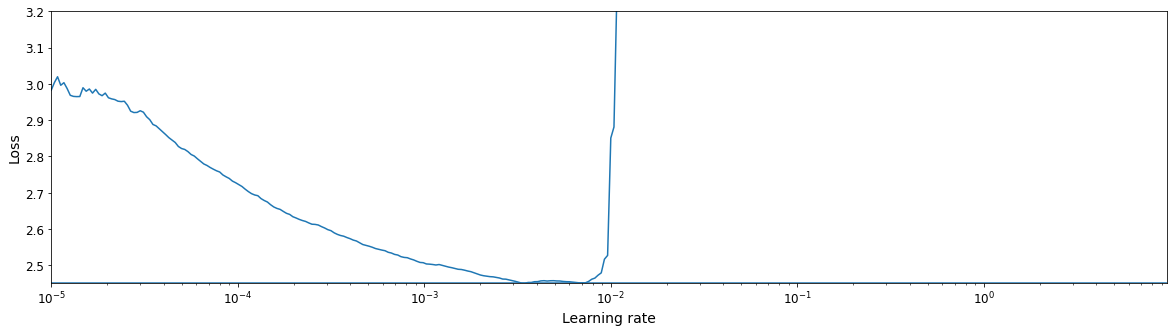

In [234]:
plt.figure(figsize=(20,5))
plot_lr_vs_loss(rates, losses, max_loss=3.2)

In [242]:
lr1 = 2e-2

## Train Model

**Callbacks**

In [243]:
# One Cycle
n_epochs = 15
batch_size = 128
onecycle_cb = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=lr1)

model_id = "a_drop_1cycle_model"

# Checkpoint
cp_model_name = os.path.join(MODEL_DIR, model_id + "_checkpoint.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(cp_model_name, save_best_only=True)

# Tensorboard
run_index = 3
run_logdir = os.path.join(LOG_DIR, model_id + "_run_{:02d}".format(run_index))
print("TensorBoard directory:", run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

callbacks = [onecycle_cb, checkpoint_cb, tensorboard_cb]

TensorBoard directory: ./_tf_logs/my_cifar10/a_drop_1cycle_model_run_03


**Train**

In [244]:
reset_backend()

rate = 0.2

# create model
model = Sequential()
model.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(Dense(100, activation="selu", 
                    kernel_initializer="lecun_normal"))
model.add(AlphaDropout(rate=rate, seed=SEED))
model.add(Dense(10, activation="softmax"))

# compile
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate
    return lr

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
lr_metric = get_lr_metric(optimizer)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", lr_metric])

# train
history = model.fit(X_train_scaled, y_train, 
                    epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=callbacks)

Epoch 1/15
352/352 [==============================] - 4s 9ms/step - loss: 2.2479 - accuracy: 0.2337 - lr: 0.0033 - val_loss: 1.8344 - val_accuracy: 0.3614 - val_lr: 0.0047
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.9098 - accuracy: 0.3281 - lr: 0.0060 - val_loss: 1.7390 - val_accuracy: 0.4018 - val_lr: 0.0073
Epoch 3/15
352/352 [==============================] - 3s 7ms/step - loss: 1.7358 - accuracy: 0.3843 - lr: 0.0087 - val_loss: 1.7348 - val_accuracy: 0.4146 - val_lr: 0.0100
Epoch 4/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6250 - accuracy: 0.4231 - lr: 0.0113 - val_loss: 1.6418 - val_accuracy: 0.4400 - val_lr: 0.0127
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.5451 - accuracy: 0.4508 - lr: 0.0140 - val_loss: 1.7703 - val_accuracy: 0.4154 - val_lr: 0.0153
Epoch 6/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4905 - accuracy: 0.4718 - lr: 0.0167 - val_loss: 1.7154 - val_ac

## Evaluate

Clearly overfit the training data, so let's get best model.

In [245]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.6749 - accuracy: 0.5091 - lr: 5.7698e-06


[1.674898624420166, 0.5091000199317932, 5.76980028199614e-06]

# WHAT I DID WRONG!

- Bad learning rates (try using bigger batch sizes and 1 epoch)
- Too many dropout layers
<br>

**Basically, I did not apply the right methods to debug when the model underfitted or overfitted.**